In [ ]:
import os, sys
import random
import pandas as pd
import numpy as np
import numpy
#import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import cv2
import pandas as pd
import math
import time

from tqdm import tqdm

from torchvision import datasets, transforms
from transformers import GLPNForDepthEstimation, GLPNFeatureExtractor
from transformers import DetrFeatureExtractor, DetrForObjectDetection
from PIL import Image
from transformers import GLPNForDepthEstimation, GLPNFeatureExtractor

In [ ]:
scene1_clone = os.listdir('/content/drive/MyDrive/Notebooks/data/VKITTI/Scene01/clone/frames/rgb/Camera_1')
scene1_fog = os.listdir('/content/drive/MyDrive/Notebooks/data/VKITTI/Scene01/fog/frames/rgb/Camera_1')

print(len(scene1_clone)) # 447개
print(len(scene1_fog))

447
447


In [ ]:
scene1_clone_bbox = pd.read_csv('/content/drive/MyDrive/Notebooks/data/VKITTI_txt/vkitti_2.0.3_textgt/Scene01/clone/bbox.txt', delimiter=' ')
scene1_clone_info = pd.read_csv('/content/drive/MyDrive/Notebooks/data/VKITTI_txt/vkitti_2.0.3_textgt/Scene01/clone/info.txt', delimiter=' ')
scene1_clone_pose = pd.read_csv('/content/drive/MyDrive/Notebooks/data/VKITTI_txt/vkitti_2.0.3_textgt/Scene01/clone/pose.txt', delimiter=' ')

In [ ]:
scene1_clone_bbox

In [ ]:
scene1_clone_info

,trackID,label,model,color
0,0,Car,Sedan4Door,Black
1,1,Car,Hatchback,Black
2,2,Car,Hybrid,Black
3,3,Car,Hatchback,Red
4,4,Car,Hatchback,Silver
...,...,...,...,...
88,81,Car,Hatchback,Grey
89,86,Car,Sedan4Door,White
90,83,Car,Hatchback,Black
91,84,Car,Sedan4Door,Black


In [ ]:
# 데이터 feature 추출

# bbox 데이터에서 xmin, ymin, xmax, ymax value 뽑아내기
# camera_ID == 1만 사용
scene1_clone_bbox.rename(columns={'left':'xmin', 'right':'xmax', 'top':'ymin', 'bottom':'ymax'}, inplace=True)
scene1_clone_bbox = scene1_clone_bbox[scene1_clone_bbox['cameraID']==1][['xmin','ymin','xmax','ymax','trackID','frame']]

filename = [scene1_clone[fr] for fr in scene1_clone_bbox['frame'].values]
scene1_clone_bbox.drop('frame', axis=1, inplace=True)

# trackID에 맞는 label을 대응
label_list = [scene1_clone_info[scene1_clone_info['trackID']==trackID]['label'].values[0] \
              for trackID in scene1_clone_bbox['trackID'].values] 
scene1_clone_bbox.drop('trackID', axis=1, inplace=True)

scene1_clone_pose.rename(columns={'camera_space_Z':'zloc', 'alpha':'angle'}, inplace=True)
scene1_clone_pose = scene1_clone_pose[scene1_clone_pose['cameraID']==1][['angle','zloc']]

scene1_clone_bbox.reset_index(inplace=True)
scene1_clone_pose.reset_index(inplace=True)
scene1_clone_bbox.drop('index', axis=1, inplace=True)
scene1_clone_pose.drop('index', axis=1, inplace=True)

In [ ]:
print(len(scene1_clone_bbox))
print(len(label_list))
print(len(scene1_clone_pose))
print(len(filename))

6953
6953
6953
6953


In [ ]:
scene1_clone_data = pd.DataFrame({'filename':filename})
scene1_clone_data['class'] = label_list
scene1_clone_data = pd.concat([scene1_clone_data, scene1_clone_bbox], axis=1)
scene1_clone_data = pd.concat([scene1_clone_data, scene1_clone_pose], axis=1)
scene1_clone_data['weather'] = 'clone'
scene1_clone_data['class'].replace({'Car':'car', 'Van':'car', 'Truck':'truck'}, inplace=True)

In [ ]:
set_filename = scene1_clone[:74]
print(set_filename)
mask = [index for index in range(len(scene1_clone_data)) if scene1_clone_data['filename'].values[index] in set_filename]
scene1_clone_data = scene1_clone_data.iloc[mask]

['rgb_00000.jpg', 'rgb_00003.jpg', 'rgb_00002.jpg', 'rgb_00004.jpg', 'rgb_00001.jpg', 'rgb_00005.jpg', 'rgb_00006.jpg', 'rgb_00009.jpg', 'rgb_00007.jpg', 'rgb_00008.jpg', 'rgb_00010.jpg', 'rgb_00014.jpg', 'rgb_00011.jpg', 'rgb_00013.jpg', 'rgb_00012.jpg', 'rgb_00015.jpg', 'rgb_00016.jpg', 'rgb_00018.jpg', 'rgb_00017.jpg', 'rgb_00020.jpg', 'rgb_00019.jpg', 'rgb_00021.jpg', 'rgb_00022.jpg', 'rgb_00023.jpg', 'rgb_00024.jpg', 'rgb_00028.jpg', 'rgb_00025.jpg', 'rgb_00027.jpg', 'rgb_00026.jpg', 'rgb_00029.jpg', 'rgb_00030.jpg', 'rgb_00031.jpg', 'rgb_00032.jpg', 'rgb_00034.jpg', 'rgb_00033.jpg', 'rgb_00035.jpg', 'rgb_00038.jpg', 'rgb_00037.jpg', 'rgb_00036.jpg', 'rgb_00039.jpg', 'rgb_00041.jpg', 'rgb_00040.jpg', 'rgb_00044.jpg', 'rgb_00043.jpg', 'rgb_00042.jpg', 'rgb_00045.jpg', 'rgb_00046.jpg', 'rgb_00047.jpg', 'rgb_00048.jpg', 'rgb_00049.jpg', 'rgb_00050.jpg', 'rgb_00051.jpg', 'rgb_00052.jpg', 'rgb_00054.jpg', 'rgb_00053.jpg', 'rgb_00055.jpg', 'rgb_00058.jpg', 'rgb_00057.jpg', 'rgb_00056.jp

In [ ]:
scene1_clone_data

NameError: ignored

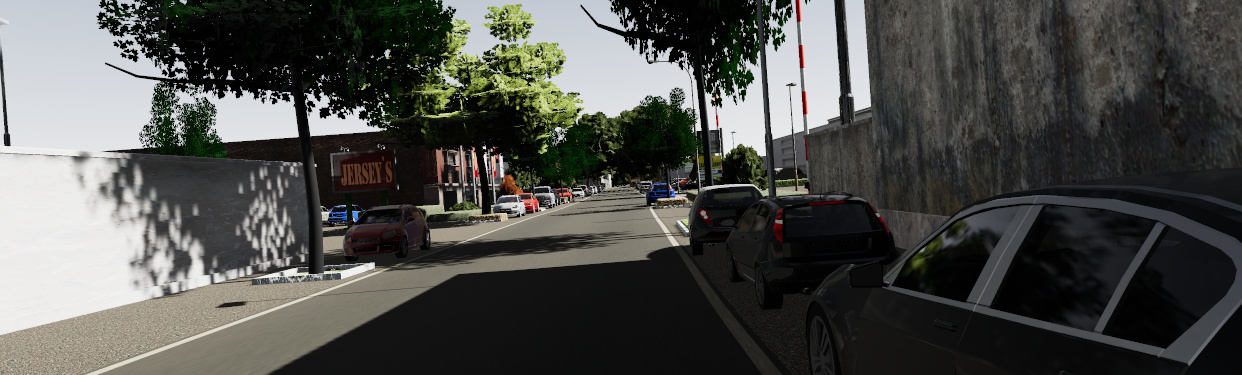

In [ ]:
k = 70
img = Image.open(os.path.join('/content/drive/MyDrive/Notebooks/data/VKITTI/Scene01/clone/frames/rgb/Camera_1',scene1_clone_data['filename'][k]))
img_shape = cv2.imread(os.path.join('/content/drive/MyDrive/Notebooks/data/VKITTI/Scene01/clone/frames/rgb/Camera_1',scene1_clone_data['filename'][k])).shape

img

In [ ]:
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# Preprocessing and bounding box
# standard PyTorch mean-std input image normalization
dpt_transform = transforms.Compose([
    #transforms.Resize(800),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

# Detection
def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)
    #img_shape = img.shape

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled

detr_101 = torch.hub.load('facebookresearch/detr:main', 'detr_resnet101', pretrained=True) # Use resnet 101
detr_101.eval()
feature_extractor = GLPNFeatureExtractor.from_pretrained("vinvino02/glpn-kitti") # glpn-nyu2
model = GLPNForDepthEstimation.from_pretrained("vinvino02/glpn-kitti")
model.eval()

Downloading: "https://github.com/facebookresearch/detr/archive/main.zip" to /root/.cache/torch/hub/main.zip
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r101-2c7b67e5.pth" to /root/.cache/torch/hub/checkpoints/detr-r101-2c7b67e5.pth


  0%|          | 0.00/232M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/137 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/920 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/234M [00:00<?, ?B/s]

GLPNForDepthEstimation(
  (glpn): GLPNModel(
    (encoder): GLPNEncoder(
      (patch_embeddings): ModuleList(
        (0): GLPNOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): GLPNOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): GLPNOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): GLPNOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
      )
      (block): ModuleList(

In [ ]:
scores, boxes = detect(img, detr_101, dpt_transform) # Detection

with torch.no_grad(): # Depth map
    pixel_values = feature_extractor(img, return_tensors="pt").pixel_values
    outputs = model(pixel_values) 
    predicted_depth = outputs.predicted_depth
    
    # interpolate to original size
    prediction = torch.nn.functional.interpolate(
                        predicted_depth.unsqueeze(1),
                        size=img_shape[:2],
                        mode="bicubic",
                        align_corners=False,
                 )
    prediction = prediction.squeeze().cpu().numpy() # shape => (375, 1242)

/root/.cache/torch/hub/facebookresearch_detr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


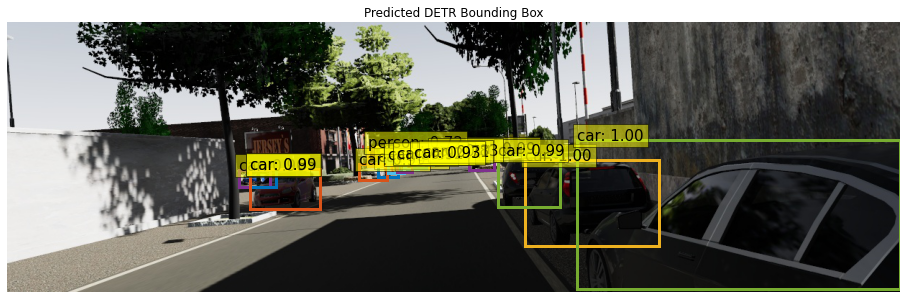

In [ ]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.title('Predicted DETR Bounding Box')
    plt.show()
    
plot_results(img, scores, boxes)

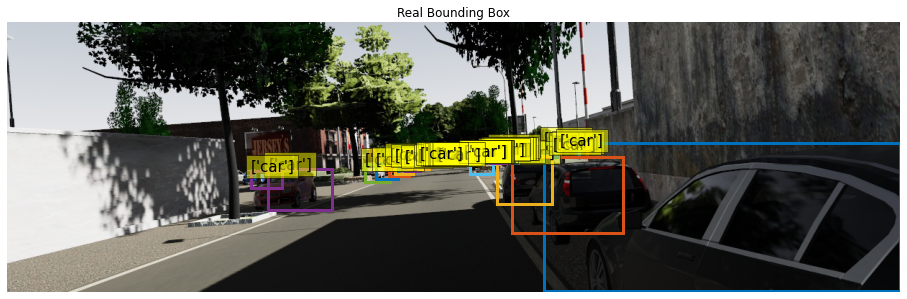

In [ ]:
mask = scene1_clone_data['filename'][k]
df_choose = scene1_clone_data.loc[scene1_clone_data['filename']==scene1_clone_data['filename'][k]]

class_list = df_choose[['class']].values
coordinates = df_choose[['xmin','ymin','xmax','ymax']].values

# 기존의 Real Data
def plot_results0(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        #cl = p.argmax()
        text = p
        ax.text(xmin, ymin, p, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.title('Real Bounding Box')
    plt.show()

plot_results0(img, class_list, coordinates)